## Load things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from ipywidgets import interact
import os,sys
# sys.addaudithook
rpath = os.getcwd()
sys.path.insert(0,"../")
# import utils

import dimred ### library of dimension reduction

In [2]:
import ipywidgets
from ipywidgets import interact

from dimred.data.loader import LoadOne
from dimred.data.preprocess import MinMaxScalar,ZeroMeanScalar,MeanMaxScalar,AvgMaxScalar
# dimred.
from dimred.data.preprocess import scale_sanity,Scalar,Shaper,scaleMax

from dimred.models.linear.transform import Kurtosis
from dimred.models.linear.transform import co_variance,co_kurtosis
from dimred.tester.plotting import plot_embedding,plot_compare
from dimred.tester.metrics import mean_sq_error,mean_abs_error

from dimred.gaspipe import transform_step,cantera_step,build_dictionary,retain_analysis
from dimred.tester.plotting import plot_spectra,img_compare,plot_bars

## Read data

In [4]:
loader = LoadOne()

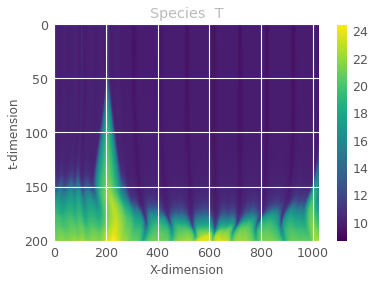

In [5]:
xregions = [loader.getData()]
loader.plotImg(spec=12)#,aspect=0.9)

domains = (1,4)
xregions.extend(loader.getDomain(domains))


In [6]:
for x in xregions:
    print(x.shape)

(201, 1024, 17)
(201, 256, 17)
(201, 256, 17)
(201, 256, 17)
(201, 256, 17)


 Transformation

- xreduced is 4D vector:
- project back to original space
- Low rank newly reconstructed matrix

co_variance reconstruction error after retaining 4 vectors is 0.0257
co_kurtosis reconstruction error after retaining 4 vectors is 0.0255


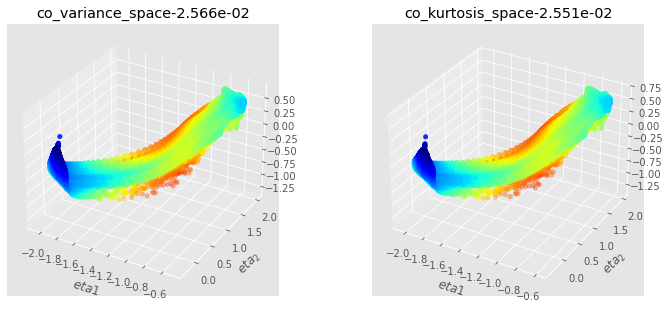

In [9]:
def mf_embed(region_id=1):
    xrig = xregions[region_id].copy()
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121, projection='3d')
    cmv,xold,xnew = transform_step(xrig,moment=co_variance, scalar=AvgMaxScalar,plt_ax=ax,verbose=False)

    ax = fig.add_subplot(122, projection='3d')
    cmk,kold,knew = transform_step(xrig,moment=co_kurtosis, scalar=AvgMaxScalar,plt_ax=ax,verbose=False)        


mf_embed(0)

In [6]:
interact(mf_embed,time_step=range(5))

interactive(children=(Dropdown(description='time_step', index=100, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, …

<function __main__.mf_embed(time_step=100)>

co_variance reconstruction error after retaining 4 vectors is 0.0134
co_kurtosis reconstruction error after retaining 4 vectors is 0.0135


/home/shubham/strial/mdimred/examples/../dimred/tester/plotting.py:51: RuntimeWarning: divide by zero encountered in log
  ax1.plot(np.log(s1),'--ob',label='covariance')
/home/shubham/strial/mdimred/examples/../dimred/tester/plotting.py:52: RuntimeWarning: divide by zero encountered in log
  ax1.plot(np.log(s2),'--or',label='cokurtosis')


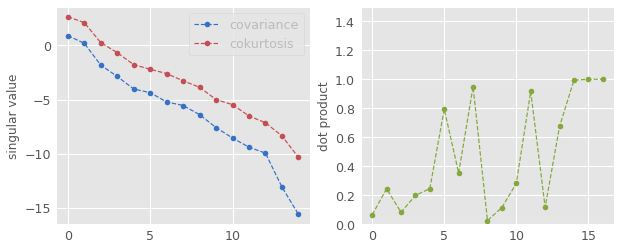

In [10]:
def mf_orient(region_id=1):
    # time_step = 100
    xrig = xregions[region_id].copy()

    cmv,xold,xnew = transform_step(xrig,moment=co_variance, scalar=AvgMaxScalar,verbose=False,plots=False)
    cmk,kold,knew = transform_step(xrig,moment=co_kurtosis, scalar=AvgMaxScalar,verbose=False,plots=False)
    plot_spectra(cmv.s,cmk.s,cmv.u,cmk.u)

mf_orient()

In [11]:

interact(mf_orient,region_id=range(5))

interactive(children=(Dropdown(description='region_id', index=1, options=(0, 1, 2, 3, 4), value=1), Output()),…

<function __main__.mf_orient(region_id=1)>

Average Error is 0.0000


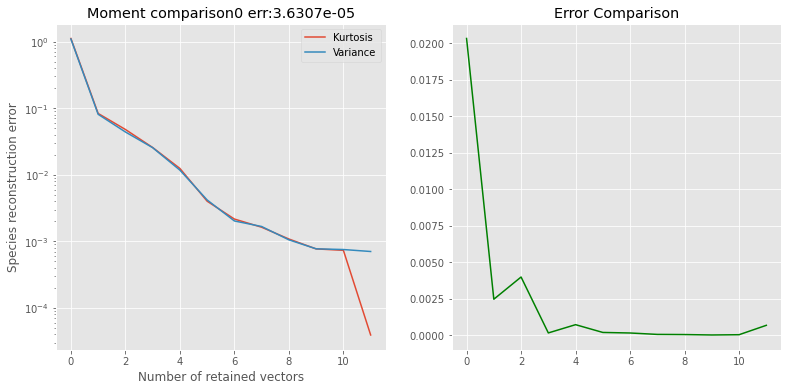

In [6]:
def mf_retain(region_id=0,scale='log'):
    # xrig = loader.getTime(time_step,verbose=-1)[:,:14]
    spr = Shaper()
    xrig = spr.fit_transform(xregions[region_id].copy())

    verr = retain_analysis(xrig,moment=co_variance).reshape(-1,1)
    kerr = retain_analysis(xrig,moment=co_kurtosis).reshape(-1,1)
    fig = plot_compare(verr,kerr,titler="Moment comparison",species=0,labels=["Variance","Kurtosis"])
    fig.axes[0].set_xlabel("Number of retained vectors")
    fig.axes[0].set_ylabel("Species reconstruction error")
    fig.axes[0].set_yscale(scale)

mf_retain(2)


In [11]:
interact(mf_retain,region_id=range(5),scale=['linear','log'])

interactive(children=(Dropdown(description='time_step', index=100, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, …

<function __main__.mf_retain(time_step=100, scale='log')>

## Interactive!

In [7]:
region_id = 1
num_retain=4
spr = Shaper()

xrig = spr.fit_transform(xregions[region_id])
total = build_dictionary(xrig,retain=num_retain)


co_variance reconstruction error after retaining 4 vectors is 0.0134
co_kurtosis reconstruction error after retaining 4 vectors is 0.0135


In [9]:
def f(moment,source,specs=0):
    plot_compare(total[moment]['old'][source],
                 total[moment]['new'][source],species=specs)

interact(f,moment=total.keys(),source=total['covariance']['old'].keys(),specs=loader.varid)

interactive(children=(Dropdown(description='moment', options=('covariance', 'cokurtosis'), value='covariance')…

<function __main__.f(moment, source, specs=0)>

In [9]:
# spr.transform2(total[moment]['old'][source])

In [12]:
import pandas as pd

In [8]:
def f(moment,source,specs=0):
    img_compare(spr.transform2(total[moment]['old'][source]),
                 spr.transform2(total[moment]['new'][source]),species=specs)

interact(f,moment=total.keys(),source=total['covariance']['old'].keys(),specs=loader.varid)

interactive(children=(Dropdown(description='moment', options=('covariance', 'cokurtosis'), value='covariance')…

<function __main__.f(moment, source, specs=0)>

In [36]:
# np.sum(total[moment]['old']['mass'],axis=0)
scaleMax = lambda dat : np.array([MinMaxScalar(x) for x in dat.T]).T


In [27]:
df.columns = ["Origin","Reconstruct"]

In [39]:
def abs_err(x1,x2):
    x1 = scaleMax(x1)
    x2 = scaleMax(x2)
    return np.mean(np.abs(x1-x2),axis=0)

def plot_bars(errcv,errck,horz=False,labels=["Covariance","Kurtosis"]):

    df1 = pd.DataFrame([errcv,errck]).T
    df1.columns = labels
    if horz:
        df1.plot.barh()#(kind='bar')
    else:
        df1.plot.bar()
    plt.title("Species reconstruction error")
    plt.xlabel("Reconstruction errors in source term $f(x_1,x_2)$")
    plt.ylabel("Reconstruction method")
        

In [40]:
def f(source):
    moment = "covariance"
    errcv = abs_err(total[moment]['old'][source] ,total[moment]['new'][source])
    moment = "cokurtosis"
    errck = abs_err(total[moment]['old'][source] ,total[moment]['new'][source])

    plot_bars(errcv,errck)

interact(f,source=total['covariance']['old'].keys())

interactive(children=(Dropdown(description='source', options=('production', 'reaction', 'mass'), value='produc…

<function __main__.f(source, specs=0)>

In [11]:
loader.varid

{'H2': 0,
 ' O2': 1,
 ' O': 2,
 ' OH': 3,
 ' H2O': 4,
 ' H': 5,
 ' HO2': 6,
 ' H2O2': 7,
 ' CO': 8,
 ' CO2': 9,
 ' HCO': 10,
 ' N2': 11,
 ' T': 12,
 ' P': 13,
 ' vx': 14,
 ' vy': 15,
 ' vz': 16}